In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt

import matplotlib.animation as animation
import os
import torch
import numpy as np
import pandas as pd
from functools import partial
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')


from distributions import ZeroInflatedDist, QuantizedNormal
from torch_models import MixtureOfTruncNormModel, SpatialWaves
from torch_training import train_epoch
from torch_perturb.torch_pert_topk import PerturbedBrokenTopK
from torch_perturb.perturbations import perturbed
import time
from torch_training import train_epoch_largesynth, train_epoch_largesynth_loo
from torch_models import torch_bpr_uncurried, deterministic_bpr
from metrics import top_k_onehot_indicator

2024-09-16 13:13:29.830697: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 13:13:29.955682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 13:13:29.955722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 13:13:29.961344: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 13:13:29.972706: I tensorflow/core/platform/cpu_feature_guar

In [43]:
data_dir='/cluster/home/kheuto01/code/prob_diff_topk'

step_size=0.1
perturbed_noise=0.0001
K=100
threshold=1
rows=27
cols=60
data_shape=(rows, cols)
deaths = pd.read_csv(os.path.join(data_dir,'deaths_band.csv'))
pop = pd.read_csv(os.path.join(data_dir, 'pop_band.csv'))
num_score_samples = 50
num_pert_samples = 50
bpr_weight=30
nll_weight=0

# turn the death column into a time-by-geoid array
deaths_TS = deaths.pivot(index='time', columns='geoid', values='death').values
pop_S = pop['pop'].values

T, S = deaths_TS.shape
# create latitude and longitude arrays corresponding to the row and column index of the geoids when reshaped into data_shape
lat = np.linspace(-rows/2, rows/2, rows)
lon = np.linspace(-cols/2, cols/2, cols)
lat_S, lon_S = np.meshgrid(lon, lat)
lat_S = lat_S.flatten()
lon_S = lon_S.flatten()
# create column of time values
time_T = np.arange(deaths_TS.shape[0])
time_T = torch.tensor(time_T, dtype=torch.float32)
lat_S = torch.tensor(lat_S, dtype=torch.float32)
lon_S = torch.tensor(lon_S, dtype=torch.float32)
pop_S = torch.tensor(pop_S, dtype=torch.float32)
deaths_TS = torch.tensor(deaths_TS, dtype=torch.float32)
S = pop_S.shape[0]
T = time_T.shape[0]


model  = SpatialWaves(num_waves=1,low=0, high=1000000)

optimizer = torch.optim.Adam(model.parameters(), lr=step_size)

M_score_func =  num_score_samples
M_action = M_score_func

top_k_func = partial(top_k_onehot_indicator, k=K)
perturbed_top_K_func = perturbed(top_k_func, sigma=perturbed_noise, num_samples=num_pert_samples)#PerturbedBrokenTopK(k=K, sigma=perturbed_noise, num_samples=num_pert_samples)#

In [44]:
init_vec = model.params_to_single_tensor().detach().numpy()

In [46]:
init_vec[2]=-init_vec[2]
init_vec[3]=-init_vec[3]

In [47]:
init_vec

array([ 0.18292475,  0.2576354 , -0.01050109, -0.91686094, -5.8104286 ,
        2.2870185 ], dtype=float32)

In [48]:
good_exp = '/cluster/tufts/hugheslab/kheuto01/large_synth_band_4000/bw0_nw1_ss0.1_nss100_nps100'
model = SpatialWaves(num_waves=1, low=0, high=100000)
model.load_state_dict(torch.load(good_exp + '/model.pth'))

<All keys matched successfully>

In [49]:
learned_vec = model.params_to_single_tensor().detach().numpy()

In [50]:
learned_vec

array([ 0.51477915, 12.230662  , -0.50643957, -0.4199828 , -5.2834616 ,
        0.8801297 ], dtype=float32)

In [51]:
# interpolate between the two vectors in 100 steps
steps = 100
interpolated_vecs = np.zeros((steps, len(init_vec)))
for i in range(steps):
    interpolated_vecs[i] = init_vec + (learned_vec - init_vec) * i / (steps-1)
    

In [52]:

grads= []
score_grads = []
det_bprs, pert_bprs, nlls = [], [], []
for s in range(steps):
    if s%10 == 0:
        print(s)
    model.update_params(torch.tensor(interpolated_vecs[s], dtype=torch.float32))
    grad, score_grad, det_bpr, pert_bpr, nll = get_grads(model, K, threshold, T,
                                        M_score_func, M_action,time_T,pop_S,
                                        lat_S, lon_S, deaths_TS, 
                                        perturbed_top_K_func, bpr_weight, 
                                        nll_weight)
    grads.append(grad)
    score_grads.append(score_grad)
    det_bprs.append(det_bpr)
    pert_bprs.append(pert_bpr)
    nlls.append(nll)

0


/tmp/ipykernel_69136/527308191.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
/tmp/ipykernel_69136/527308191.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))
/tmp/ipykernel_69136/527308191.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)


10
20
30
40
50
60
70
80
90


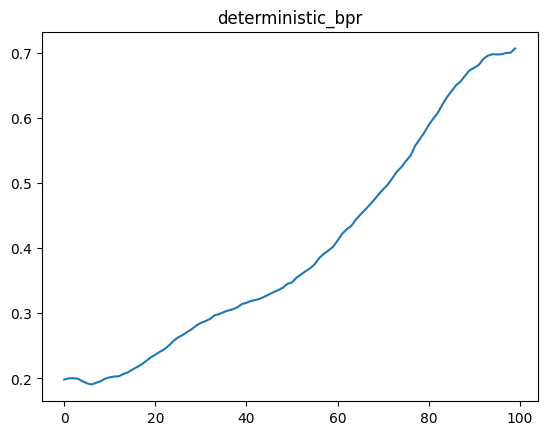

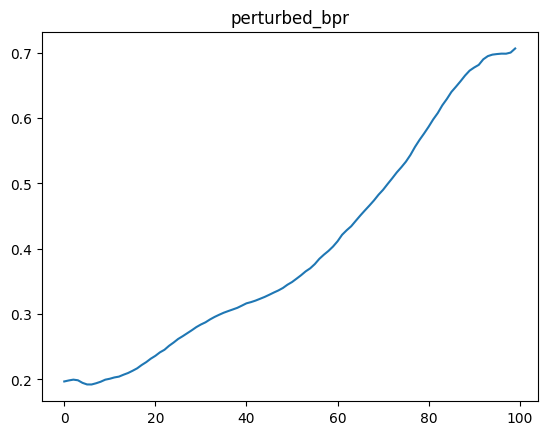

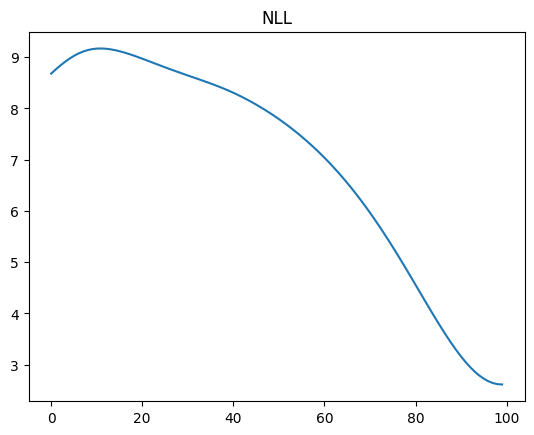

In [54]:
plt.plot(det_bprs, label='deterministic BPR')
plt.title('deterministic_bpr')
#plt.ylim([0.1,0.3])
plt.show()
plt.plot([bpr.detach() for bpr in pert_bprs], label='perturbed BPR')
plt.title('perturbed_bpr')
#plt.ylim([0.1,0.3])
plt.show()
plt.plot([nll.detach() for nll in nlls], label='NLL')
plt.title('NLL')
plt.show()

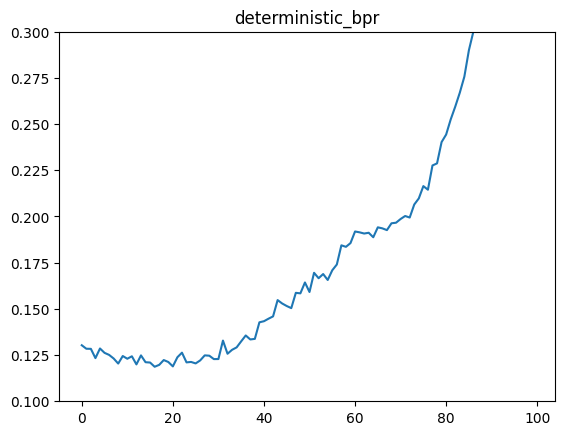

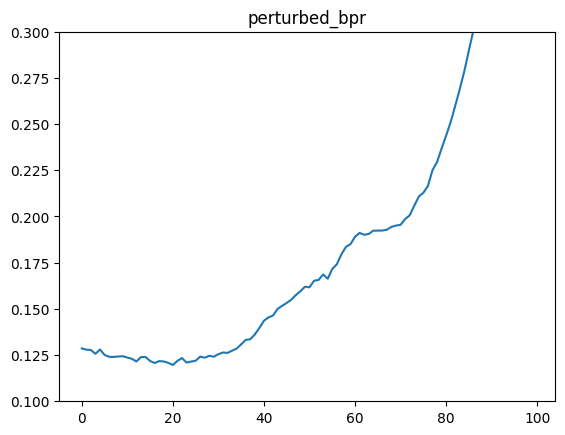

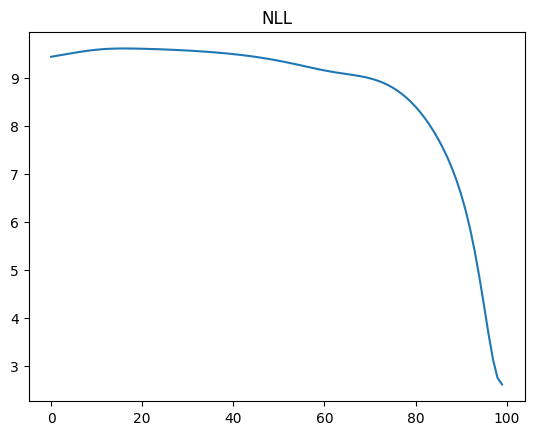

In [41]:
plt.plot(det_bprs, label='deterministic BPR')
plt.title('deterministic_bpr')
plt.ylim([0.1,0.3])
plt.show()
plt.plot([bpr.detach() for bpr in pert_bprs], label='perturbed BPR')
plt.title('perturbed_bpr')
plt.ylim([0.1,0.3])
plt.show()
plt.plot([nll.detach() for nll in nlls], label='NLL')
plt.title('NLL')
plt.show()

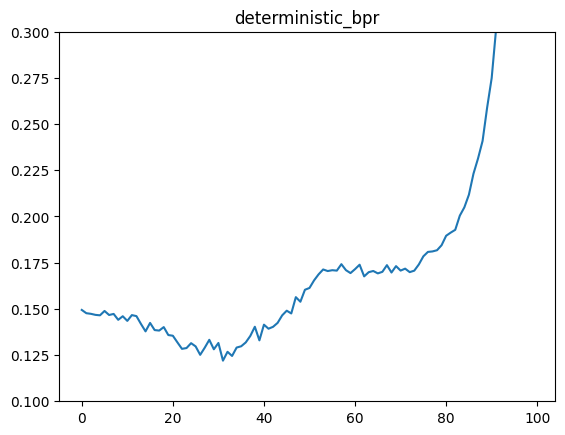

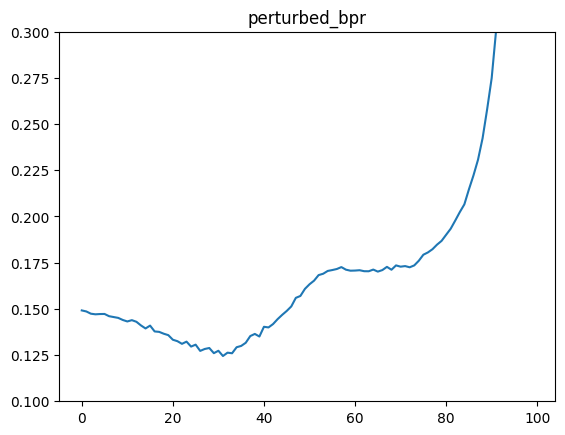

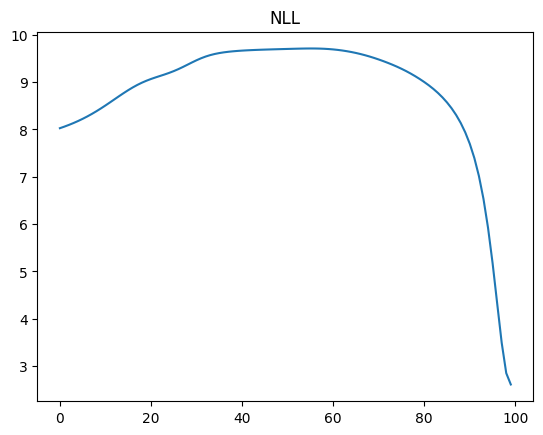

In [32]:
plt.plot(det_bprs, label='deterministic BPR')
plt.title('deterministic_bpr')
plt.ylim([0.1,0.3])
plt.show()
plt.plot([bpr.detach() for bpr in pert_bprs], label='perturbed BPR')
plt.title('perturbed_bpr')
plt.ylim([0.1,0.3])
plt.show()
plt.plot([nll.detach() for nll in nlls], label='NLL')
plt.title('NLL')
plt.show()

In [17]:
interpolated_vecs[0]


array([ 0.86075729,  0.20334113,  0.17403877,  0.6997028 , -5.47591496,
        2.88402438])

In [18]:
init_vec

array([ 0.8607573 ,  0.20334113,  0.17403877,  0.6997028 , -5.475915  ,
        2.8840244 ], dtype=float32)

In [22]:
def get_grads(model, K, threshold, T,
                           M_score_func, M_action,
                           time_T,pop_S, lat_S, lon_S, train_y_TS,
                           perturbed_top_K_func, bpr_weight, nll_weight, ):

    optimizer.zero_grad()
    dist = model(time_T,pop_S, lat_S, lon_S)
    
    y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
    y_sample_action_TMS = y_sample_TMS

    ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
    ratio_rating_TS.requires_grad_(True)

    def get_log_probs_baked(param):
        distribution = model.build_from_single_tensor(param, time_T, pop_S, lat_S, lon_S)
        log_probs_TMS = distribution.log_prob(y_sample_TMS.permute(1, 0, 2)).permute(1, 0, 2)

        return log_probs_TMS
    
    jac_TMSP = torch.autograd.functional.jacobian(get_log_probs_baked, (model.params_to_single_tensor()), strategy='forward-mode', vectorize=True)

    all_sample_tot = ratio_rating_TMS.sum(dim=-2, keepdim=True)
    all_other_sample_mean = (all_sample_tot-ratio_rating_TMS)/(T-1)
    score_func_estimator_TMSP = jac_TMSP * (ratio_rating_TMS - all_other_sample_mean).unsqueeze(-1)
    score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    


    #score_func_estimator_TMSP = jac_TMSP * ratio_rating_TMS.unsqueeze(-1)
    #score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    

    # get gradient of negative bpr_t  with respect to ratio rating_TS

    positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
    if nll_weight>0:
        bpr_threshold_diff_T = positive_bpr_T - threshold
        violate_threshold_flag = bpr_threshold_diff_T < 0
        negative_bpr_loss = torch.mean(-bpr_threshold_diff_T*violate_threshold_flag)
    else:
        negative_bpr_loss = torch.mean(-positive_bpr_T)
    
    nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))

    loss = bpr_weight*negative_bpr_loss + nll_weight*nll
    loss.backward()
    loss_grad_TS = ratio_rating_TS.grad

    score_func_grad_P = torch.sum(score_func_estimator_TSP, dim=[0,1]).detach()
 
    gradient_TSP = score_func_estimator_TSP * torch.unsqueeze(loss_grad_TS, -1)
    gradient_P = torch.sum(gradient_TSP, dim=[0,1])

    gradient_tuple = model.single_tensor_to_params(gradient_P)

    for param, gradient in zip(model.parameters(), gradient_tuple):
        if nll_weight>0:
            gradient = gradient + param.grad
        param.grad = gradient

    deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)
    det_bpr =torch.mean(deterministic_bpr_T)

    return [param.grad for param in model.parameters()], [param for param in score_func_grad_P], det_bpr,  positive_bpr_T.mean(), nll